In [1]:
import torch
from torch.autograd import Variable
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss

This code is to show how the black-box variational inference with time-independent OU processes work under the observations from OU processes. Here, we deliberately initiated the underlying OU processes on high value so that it generates a sequence of observations converging toward its mean, i.e. 0. As our variatioanl process is suitable for observations tending toward their mean, we expect the resulting posterior process looks similar to the underlying SDE. 

**Class: OU processes**

In [2]:
class OU:
    def __init__(self, t0, t1, z0, alpha, beta, sigma, dN):
        self.t0 = t0
        self.t1 = t1
        self.z0 = z0
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.pts = torch.sort(torch.cat([torch.DoubleTensor(dN-2).uniform_(t0,t1), torch.tensor([self.t0, self.t1])]))[0]
        self.trj, self.dt = self.simulate()
        
    def simulate(self):
        """
            Simulate an OU process on a set of discrete points
        """
        output = np.empty(len(self.pts))
        output[0] = self.z0
        interval = self.pts[1:] - self.pts[:-1]
        for t in range(1, len(self.pts)):
            
            # if the distance is too small, variance becomes 0
            dt = interval[t-1]
            
            mean = self.alpha + (output[t-1] - self.alpha) * np.exp(-1 * self.beta * dt)
            var = np.sqrt((self.sigma ** 2) * (1 - np.exp(-2 * self.beta * dt)) / (2 * self.beta))
            assert var > 0, "variance is negative, var:%.3f interval: %.3f" % (var, dt)
            output[t] = ss.norm.rvs(loc = mean, scale = var)
        return torch.from_numpy(output), interval

Variational inference: KL

In [3]:
class ELBO:

    """
        Given a simulated variational process, compute the gradient of the ELBO. 
    """
    def __init__(self, ou):
        self.ou = ou
        self.alpha, self.beta, self.sigma = torch.tensor([ou.alpha, ou.beta, ou.sigma])
        
    def KL_ito(self):
        """
            1. Compute the Riemann approximation to integral in KL divergence
            
        """
        # Save parameter specification from ou class
        alpha, beta, sigma = self.alpha, self.beta, self.sigma

        # Obtain integral term (via Riemann approximation, e.g. trapezoid)
        func_kl = vmap(lambda z: z ** 2)
        return ((beta ** 2) - 1 ) / 2  * torch.trapezoid(abs(func_kl(self.ou.trj)), x=self.ou.pts)
    
    def KL_rest(self):
        """
            2. Compute the rest
        """

        alpha, beta, sigma = self.alpha, self.beta, self.sigma
        z0 = self.ou.z0
        z1 = self.ou.trj[-1]
        t0 = self.ou.t0
        t1 = self.ou.t1
        
        # Obtain the rest 
        def A(u):
            return (u ** 2) / 2
        
        return (1 + beta) * (A(z1) - A(z0) - ((t1 - t0) / 2))
    
    def log_prob(self, obs):
        """
            Compute the log-likelihood
            likelihood function is normal density N(obs, var)
        """
        def log_pdf(obs, z):
            return ss.norm.logpdf(obs, loc=z, scale=.001)
            
        
        return log_pdf(obs, self.ou.trj[-1])


In [4]:
class Score:
    def __init__(self, ou):
        self.ou = ou
        
    def compute_score(self, beta):
        """
            Compute the value of the score function at given parameters
            return a dictionary matching each parameter to its gradient
        """
        beta = Variable(beta, requires_grad=True)
        alpha = torch.tensor(self.ou.alpha)
        sigma = torch.tensor(self.ou.sigma)
        dt = self.ou.dt
        X = self.ou.trj
        
        def compute_transition(X, dt, alpha, beta, sigma):
            """
            Compute the transition density of the (simulated) path
            """
            term1 = -1/2 * (2 * torch.log(sigma) - torch.log(beta) + torch.log(1 - torch.exp(-2 * beta * dt)))
            term2 = -1 * beta * (X[1:] - alpha - (X[:-1] - alpha) * torch.exp(-1 * beta * dt)) ** 2 
            term3 = (sigma ** 2) * (1 - torch.exp(-2 * beta * dt))

            return torch.sum(term1 + term2/term3)
        
        NLL = compute_transition(X, dt, alpha, beta, sigma)
        
        NLL.backward()
         
        return {'beta':beta.grad.detach().clone()}


In [5]:
class MLE:
    def __init__(self, ou):
        self.ou = ou
        
    def compute_score(self, beta):
        """
            Compute the value of the score function at given parameters
            return a dictionary matching each parameter to its gradient
        """
        alpha = torch.tensor(self.ou.alpha)
        sigma = torch.tensor(self.ou.sigma)
        beta = Variable(beta, requires_grad=True)
        dt = self.ou.dt
        X = self.ou.trj

        def compute_transition(X, dt, alpha, beta, sigma):
            """
            Compute the transition density of the (simulated) path
            """
            term1 = -1/2 * (- torch.log(beta) + torch.log(1 - torch.exp(-2 * beta * dt)))
            term2 = -1 * beta * (X[1:] - alpha - (X[:-1] - alpha) * torch.exp(-1 * beta * dt)) ** 2 
            term3 = (sigma ** 2) * (1 - torch.exp(-2 * beta * dt))

            return torch.sum(term1 + term2/term3)
        
        NLL = compute_transition(X, dt, alpha, beta, sigma)
        
        NLL.backward()
        
        return {'beta':beta.grad.detach().clone()}
    
    def LLN(self, beta):
        alpha = torch.tensor(self.ou.alpha)
        sigma = torch.tensor(self.ou.sigma)
        beta = torch.tensor(beta)
        dt = self.ou.dt
        X = self.ou.trj
        """
        Compute the transition density of the (simulated) path
        """
        term1 = -1/2 * ( - torch.log(beta) + torch.log(1 - torch.exp(-2 * beta * dt)))
        term2 = -1 * beta * (X[1:] - alpha - (X[:-1] - alpha) * torch.exp(-1 * beta * dt)) ** 2 
        term3 = (sigma ** 2) * (1 - torch.exp(-2 * beta * dt))

        return torch.sum(term1 + term2/term3)

**Generate observations from Gaussian likelihood**

Noisy Observations from the SDE:

$dX_{t} = -X_{t}dt + \sigma dW_{t}$

In [18]:
true_sde = OU(t0 = 0, t1 = 6., z0 = 10, alpha = 0, beta = 1., sigma = 1., dN=1000)

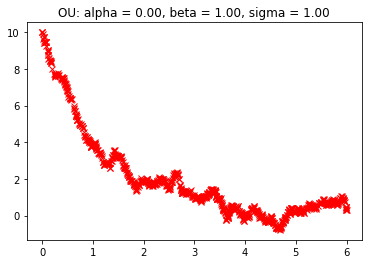

In [19]:
plt.plot(true_sde.pts, true_sde.trj, 'rx')
plt.title("OU: alpha = %.2f" % true_sde.alpha + ", beta = %.2f" % true_sde.beta + ", sigma = %.2f" % true_sde.sigma)
plt.show()

In [20]:
obs = np.random.normal(loc = true_sde.trj[::100], scale = .001)
obs_time = true_sde.pts[::100]

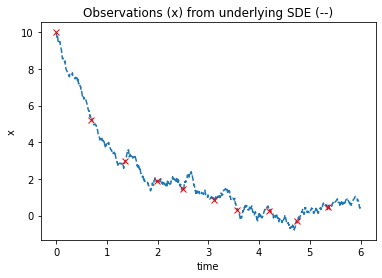

In [21]:
plt.title("Observations (x) from underlying SDE (--)")
plt.plot(true_sde.pts, true_sde.trj, '--')
plt.plot(true_sde.pts[::100], obs, 'rx')
plt.xlabel("time")
plt.ylabel("x")
plt.show()

**Variational inference: a piece-wise approximation**

1. one-time variational inference from t=0 to t=1

In [36]:
import tqdm as tq

In [65]:
beta_ = 5.

N = 50
N_e = 50
learning_rate = 0.0000001

trace_beta = []
trace_elbo = []
for k in tq.tqdm(range(300)):
    beta_grad = 0.

    for i in range(N):
        vi = OU(t0 = obs_time[0], t1 = obs_time[1], z0 = obs[0], alpha = 0 , beta = beta_ , sigma = 1., dN=20)
        elbo = ELBO(vi)
        score = Score(vi)
        
        scores = score.compute_score(torch.tensor(beta_, dtype=torch.float64))
        f_of_X = -1 * (elbo.log_prob(obs[1]) + elbo.KL_ito() + elbo.KL_rest())
        beta_grad += f_of_X * scores['beta']
     
    beta_ -= learning_rate * (beta_grad/N).numpy()
#     print(beta_)
    elbo_estimate = 0
    for j in range(N_e):
        vi_ = OU(t0 = obs_time[0], t1=obs_time[1], z0 = obs[0], alpha = 0 , beta = beta_ , sigma = 1., dN=20)
        elbo_ = ELBO(vi_)
        elbo_estimate += -1 * (elbo_.log_prob(obs[1]) + elbo_.KL_ito() + elbo_.KL_rest())
    
    elbo_estimate *= 1/N_e
    
    trace_beta.append(beta_)
    trace_elbo.append(elbo_estimate)
# score.compute_score()

100%|████████████████████████████████████████████████| 300/300 [00:59<00:00,  5.03it/s]


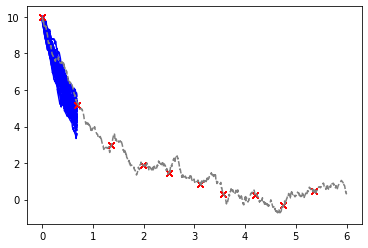

In [66]:
for i in range(50):
    posterior = OU(t0 = obs_time[0], t1 = obs_time[1], z0 = obs[0], alpha = 0 , beta = beta_ , sigma = 1., dN=100)
    plt.plot(posterior.pts, posterior.trj, 'b')
    plt.plot(obs_time, obs, 'rx')
plt.plot(true_sde.pts,true_sde.trj, 'grey', linestyle='dashed')

**Trace plot: gradient**

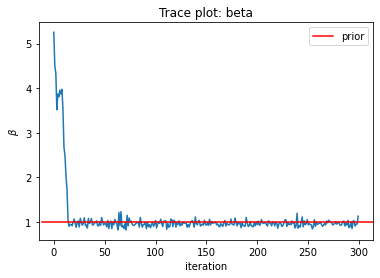

In [67]:
plt.title("Trace plot: beta")
plt.plot(np.arange(len(trace_beta)), trace_beta)
plt.axhline(1.0, xmin=0.01, xmax=300, color='red', label='prior')
plt.legend()
plt.xlabel("iteration")
plt.ylabel(r"$\beta$")
plt.show()

Trace plot: ELBO

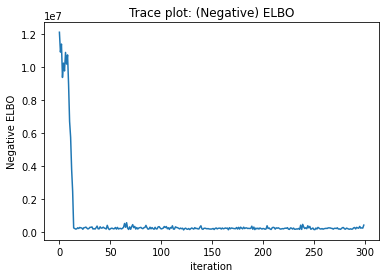

In [68]:
plt.title("Trace plot: (Negative) ELBO")
plt.plot(np.arange(len(trace_elbo)), trace_elbo)
plt.xlabel("iteration")
plt.ylabel("Negative ELBO")
plt.show()

**Posterior moment based on the average of last 30 iterations of beta**

In [69]:
def posterior_moment(init, alpha, beta):
    sigma = 1.
    pts = np.linspace(0,1,100)
    dt = pts[1:] - pts[:-1]
    
    mean = [init]
        
    for i in range(dt.shape[0]):
        mean.append(alpha + (mean[i] - alpha)*np.exp(-1 * beta * dt[i]))
    
    func = lambda t: np.sqrt((sigma ** 2 / (2*beta)) * (1 - np.exp(-2 * beta * t)))
    sd = list(map(func, dt))
    
    return np.array(mean), np.array(sd)

In [70]:
pmean, psd = posterior_moment(obs[0], 0, beta_)

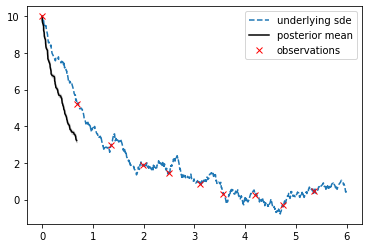

In [71]:
plt.plot(true_sde.pts, true_sde.trj, linestyle='dashed', label='underlying sde')
plt.plot(true_sde.pts[:100], pmean, 'black', label='posterior mean')
plt.fill_between(true_sde.pts[1:100], pmean[1:] - psd, pmean[1:] + psd, alpha=0.3, color='grey')
plt.plot(obs_time, obs, 'rx', label='observations')
plt.legend()
plt.show()

2. Complete piece-wise optimization from t=0 to t=10

We use the posterior mean of the previous step as our initial value for next vi

In [57]:
N = 50
N_e = 50
learning_rate = 0.00000005
z0 = obs[0]
vi_beta = np.empty(9)
IT = 300

elbo_traces = np.empty((9, IT))
beta_traces = np.empty((9, IT))

for t in tq.tqdm(range(obs.shape[0]-1)):
    beta_ = np.random.uniform(3, 6)
    
    trace = []
    for i in range(IT):
        beta_grad = 0.
            
        for k in range(N):
            vi = OU(t0 = obs_time[t], t1 = obs_time[t+1], z0 = z0, alpha = 0 , beta = beta_ , sigma = 1., dN=30)
            elbo = ELBO(vi)
            score = Score(vi)

            scores = score.compute_score(torch.tensor(beta_, dtype=torch.float64))
            f_of_X = -1 * (elbo.log_prob(obs[t+1]) + elbo.KL_ito() + elbo.KL_rest())
            
            beta_grad += f_of_X * scores['beta']

        beta_ -= learning_rate * (beta_grad/N).numpy()
        beta_traces[t, i] = beta_
        
        elbo_estimate = 0
        for j in range(N_e):
            vi_ = OU(t0 = obs_time[t], t1=obs_time[t+1], z0 = z0, alpha = 0 , beta = beta_ , sigma = 1., dN=30)
            elbo_ = ELBO(vi_)
            elbo_estimate += -1 * (elbo_.log_prob(obs[t+1]) + elbo_.KL_ito() + elbo_.KL_rest())
    
        elbo_estimate *= 1/N_e
        if i % 100 == 0:
            print("beta = ", beta_, "elbo = ", elbo_estimate)
        elbo_traces[t, i] = elbo_estimate

    vi_beta[t] = np.mean(beta_traces[t, -30:])
    
    z0 *= np.exp(-1 * vi_beta[t] * (obs_time[t+1] - obs_time[t]))
    
# score.compute_score()

  0%|                                                            | 0/9 [00:00<?, ?it/s]

beta =  3.748543398651127 elbo =  tensor(10171026.5359, dtype=torch.float64)
beta =  0.9553202565816203 elbo =  tensor(212487.1670, dtype=torch.float64)
beta =  1.0034612213199359 elbo =  tensor(234258.2188, dtype=torch.float64)


 11%|█████▊                                              | 1/9 [01:24<11:15, 84.38s/it]

beta =  3.194804391414906 elbo =  tensor(3016010.2694, dtype=torch.float64)
beta =  0.8124294436351629 elbo =  tensor(168469.0327, dtype=torch.float64)
beta =  0.812139593460044 elbo =  tensor(212385.3716, dtype=torch.float64)


 22%|███████████▌                                        | 2/9 [02:49<09:53, 84.85s/it]

beta =  4.662369728671077 elbo =  tensor(1495842.5178, dtype=torch.float64)
beta =  3.524899543744532 elbo =  tensor(1150135.2516, dtype=torch.float64)
beta =  1.471160722452545 elbo =  tensor(406955.7835, dtype=torch.float64)


 33%|█████████████████▎                                  | 3/9 [04:14<08:30, 85.03s/it]

beta =  4.409343938468485 elbo =  tensor(749333.1315, dtype=torch.float64)
beta =  3.7819442502516174 elbo =  tensor(771547.4543, dtype=torch.float64)
beta =  2.9864582358276976 elbo =  tensor(595808.5507, dtype=torch.float64)


 44%|███████████████████████                             | 4/9 [05:43<07:12, 86.47s/it]

beta =  5.33841445340371 elbo =  tensor(496973.3119, dtype=torch.float64)
beta =  5.315102020377757 elbo =  tensor(345745.3490, dtype=torch.float64)
beta =  5.311471324505199 elbo =  tensor(402951.3707, dtype=torch.float64)


 56%|████████████████████████████▉                       | 5/9 [07:09<05:45, 86.35s/it]

beta =  4.9913621100767624 elbo =  tensor(79507.1188, dtype=torch.float64)
beta =  5.041802868566363 elbo =  tensor(73486.5958, dtype=torch.float64)
beta =  5.08433892406788 elbo =  tensor(92759.1443, dtype=torch.float64)


 67%|██████████████████████████████████▋                 | 6/9 [08:34<04:17, 85.75s/it]

beta =  3.914919355295384 elbo =  tensor(84366.3697, dtype=torch.float64)
beta =  3.9923170707380757 elbo =  tensor(113727.4142, dtype=torch.float64)
beta =  4.069429396197157 elbo =  tensor(80469.4566, dtype=torch.float64)


 78%|████████████████████████████████████████▍           | 7/9 [09:58<02:50, 85.32s/it]

beta =  4.398259864840508 elbo =  tensor(83633.9294, dtype=torch.float64)
beta =  4.4669825433271155 elbo =  tensor(148427.0720, dtype=torch.float64)
beta =  4.534965693760787 elbo =  tensor(101351.0143, dtype=torch.float64)


 89%|██████████████████████████████████████████████▏     | 8/9 [11:23<01:25, 85.09s/it]

beta =  4.536674679830252 elbo =  tensor(155331.2997, dtype=torch.float64)
beta =  4.591881530315109 elbo =  tensor(221900.5016, dtype=torch.float64)
beta =  4.649163075837043 elbo =  tensor(182375.7206, dtype=torch.float64)


100%|████████████████████████████████████████████████████| 9/9 [12:47<00:00, 85.28s/it]


Trace plot: ELBO

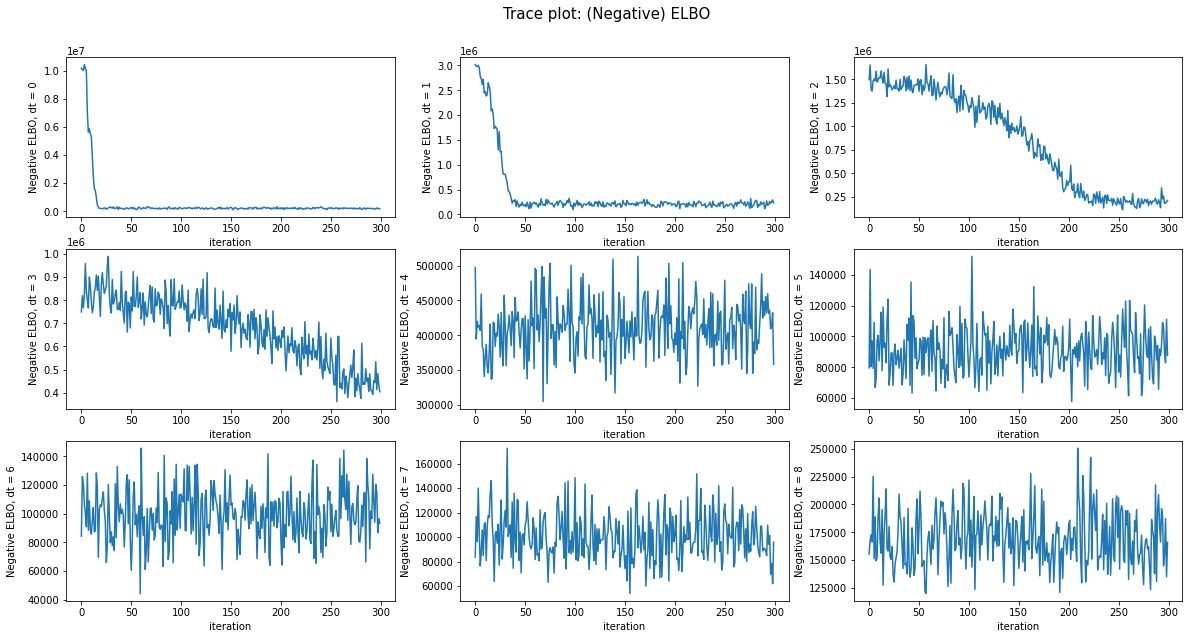

In [58]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(elbo_traces[t, :IT])), elbo_traces[t, :IT])
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative ELBO, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) ELBO", size=15, y=0.95)
plt.show()

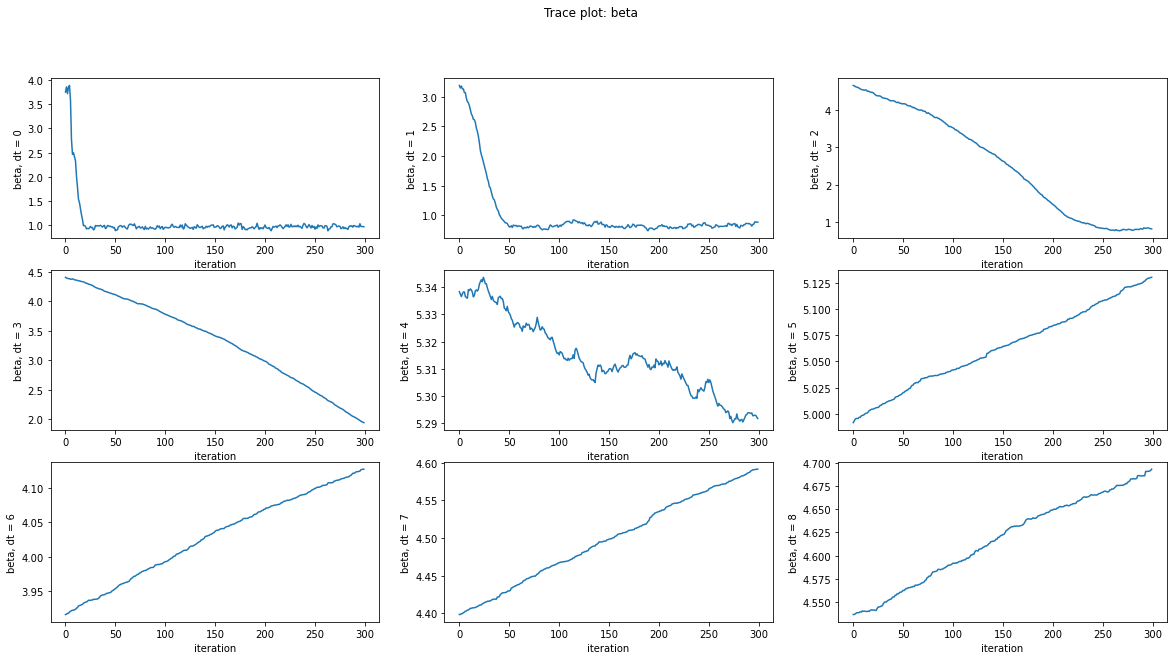

In [59]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(beta_traces[t, :IT])), beta_traces[t, :IT])
    ax.set_xlabel("iteration")
    ax.set_ylabel("beta, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: beta")
plt.show()

In [60]:
def g_posterior_moment(init, alpha, vi_beta, t0, t1):
    """
        Obtain credible interval
            posterior mean and variance are computed based on the theory (using fitted variational parameter at each interval)
    """
    sigma = 1.
    pts = np.linspace(t0,t1,900)
    dt = pts[1:] - pts[:-1]
    
    mean = [init]
    var = list(map(lambda t: np.sqrt((sigma ** 2 / (2*vi_beta[0])) * (1 - np.exp(-2 * vi_beta[0] * t))), dt[:100]))
    
    k = 0
    for j in range(dt.shape[0]):
        if j % 100 == 0:
            beta = vi_beta[k]
            k += 1
        mean.append(alpha + (mean[j] - alpha)*np.exp(-1 * beta * dt[j]))
        if (j % 100 == 0) and (j > 0):
            func = lambda t: np.sqrt((sigma ** 2 / (2*beta)) * (1 - np.exp(-2 * beta * t)))
            var += list(map(func, dt[j-100:j]))
    return np.array(mean), np.array(var)

In [61]:
pmean, pvar = g_posterior_moment(obs[0], 0, vi_beta, 0, 6)

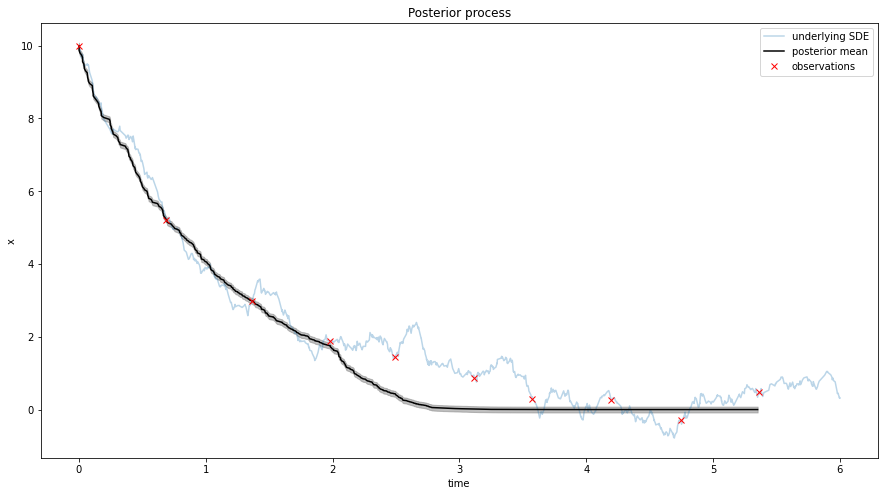

In [63]:
plt.figure(figsize=(15,8))
plt.title("Posterior process")
plt.plot(true_sde.pts, true_sde.trj, alpha=0.3, label='underlying SDE')
plt.plot(true_sde.pts[:900], pmean, 'black', label='posterior mean')
plt.fill_between(true_sde.pts[:900], pmean - pvar, pmean + pvar, alpha=0.5, color='grey')
plt.plot(obs_time, obs, 'rx', label='observations')
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()